<font size="+3" color='#4085f5'><b> Land-Cover Classification with EuroSAT Dataset </b></font>

Land-cover image classification, mengidentifikasi gambar yang diambil dari satelit dan menentukan jenis kelompok
land-cover atau tutupan lahan dari gambar yang diambil


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.utils import shuffle

from tensorflow.keras import models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Reshape, Conv2DTranspose, Input
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation

from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing the dataset

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Dafa-Argy CNN/eurosat_gs.csv')
data

,Pixels,Class,Usage
0,84 84 84 89 94 101 111 114 116 117 117 119 120...,0,Training
1,87 87 82 86 85 85 86 86 87 85 86 87 90 89 94 1...,0,Training
2,76 76 70 64 62 59 55 57 56 53 54 55 56 65 76 9...,0,Training
3,113 113 127 153 156 153 160 167 167 170 171 17...,0,Training
4,148 148 149 151 151 150 150 149 149 149 150 15...,0,Training
...,...,...,...
26995,58 58 58 58 57 58 60 58 58 59 57 58 58 59 59 5...,9,Test
26996,57 57 56 56 54 56 56 56 56 56 56 56 55 55 57 5...,9,Test
26997,41 41 42 41 41 41 42 41 41 41 41 41 41 40 41 4...,9,Test
26998,112 111 112 113 113 113 113 113 113 113 114 11...,9,Test


Setelah mengimport data, terdapat 10 Class atau jenis land-cover, yaitu:
* Annual Crop
* Forest
* Herbaceous Vegetation
* Highway
* Industrial
* Pasture
* Permanent Crop
* Residental
* River
* Sealake

In [ ]:
land_types = {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}

## Land-Cover Distribution

Dari dataset yang sudah diimport, dapat dilihat bahwa terdapat sebanyak 27000 dataset dengan distribusi kelompok land-cover sebagai berikut:

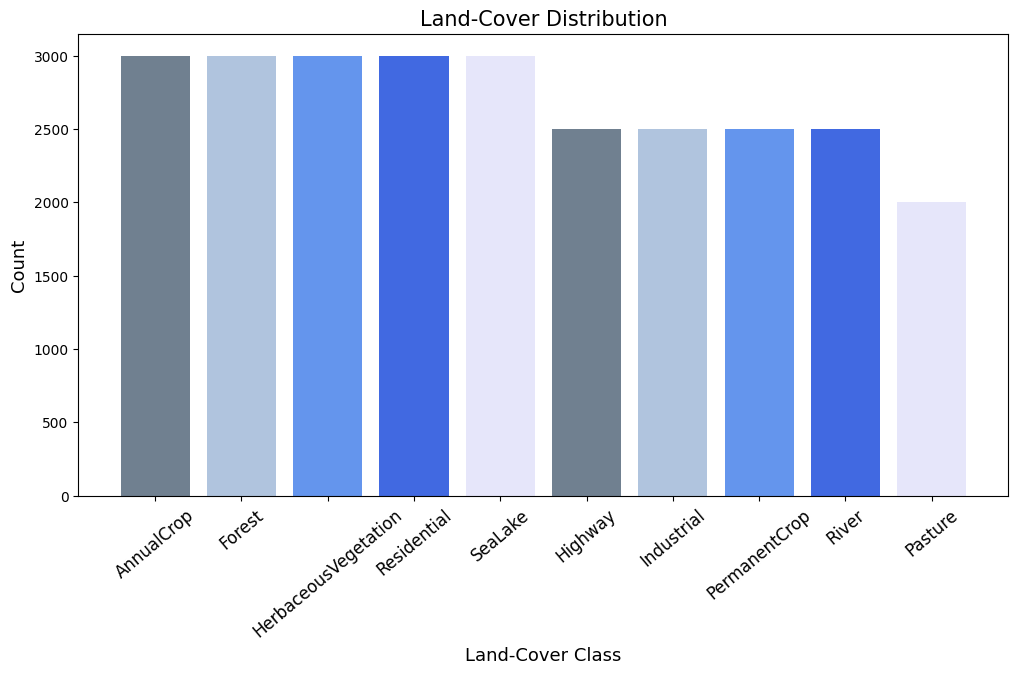

In [ ]:
# Distribution percentage of each land-cover
def get_classes_distribution(data):
    # Get the count for each label
    class_counts = data["Class"].value_counts()

    # Get total number of samples
    total_samples = len(data)


    # Count the number of items in each class
    for i in range(len(class_counts)):
        label = land_types[class_counts.index[i]]
        count = class_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}:   {} or {}%".format(label, count, percent))

#Land-cover Distribution graph
counts = data['Class'].value_counts().to_dict()

plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center', color=['slategrey', 'lightsteelblue', 'cornflowerblue', 'royalblue', 'lavender'])
plt.xticks(range(len(counts)), [land_types[key] for key in counts.keys()], fontsize=12, rotation=40)
plt.xlabel('Land-Cover Class', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.title('Land-Cover Distribution', fontsize=15)

plt.show()

Rincian Distribusi:

In [ ]:
get_classes_distribution(data)

AnnualCrop          :   3000 or 11.11111111111111%
Forest              :   3000 or 11.11111111111111%
HerbaceousVegetation:   3000 or 11.11111111111111%
Residential         :   3000 or 11.11111111111111%
SeaLake             :   3000 or 11.11111111111111%
Highway             :   2500 or 9.25925925925926%
Industrial          :   2500 or 9.25925925925926%
PermanentCrop       :   2500 or 9.25925925925926%
River               :   2500 or 9.25925925925926%
Pasture             :   2000 or 7.4074074074074066%


## Image Samples

In [ ]:
def plot_land_cover_type(data, land_types, label):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    axs = axs.ravel()

    class_data = data[data['Class'] == label]
    for i in range(5):
        idx = class_data.index[i]
        pixel_values = class_data.loc[idx, 'Pixels']
        pixel_values = np.fromstring(pixel_values, dtype=int, sep=' ').reshape(64, 64)
        pixel_values = cv2.cvtColor(pixel_values.astype(np.uint8), cv2.COLOR_BGR2RGB)

        land_type = land_types[label]
        axs[i].imshow(pixel_values)
        axs[i].set_title(f"Land Type: {land_type}")
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

    plt.show()

# All Land Types

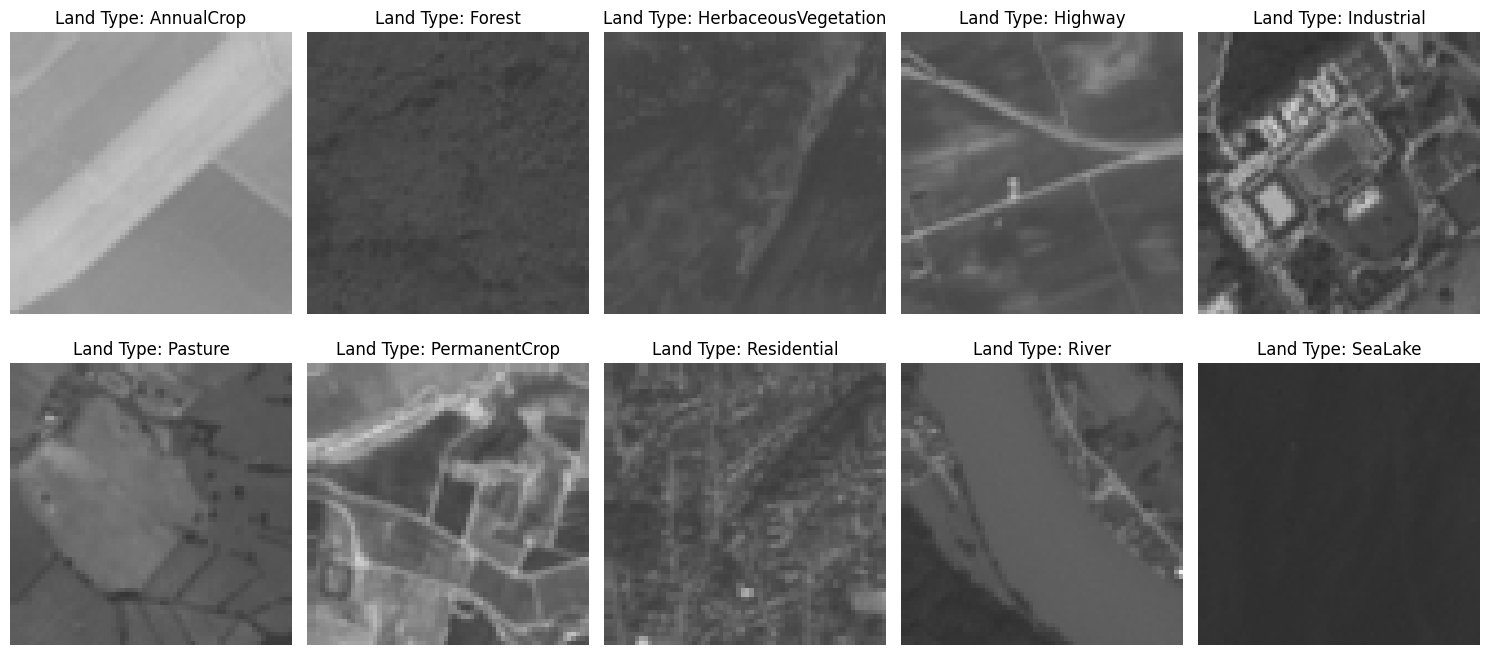

In [ ]:
random_samples = data.groupby('Class').apply(lambda x: x.sample(n=1))

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7))

for i, ax in enumerate(axes.flat):
    pixel_values = random_samples.iloc[i]['Pixels']
    pixel_values = np.fromstring(pixel_values, dtype=int, sep=' ').reshape(64, 64)
    pixel_values = cv2.cvtColor(pixel_values.astype(np.uint8), cv2.COLOR_BGR2RGB)

    label = random_samples.iloc[i]['Class']
    land_type = land_types[label]
    ax.imshow(pixel_values)
    ax.set_title(f"Land Type: {land_type}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## AnnualCrop

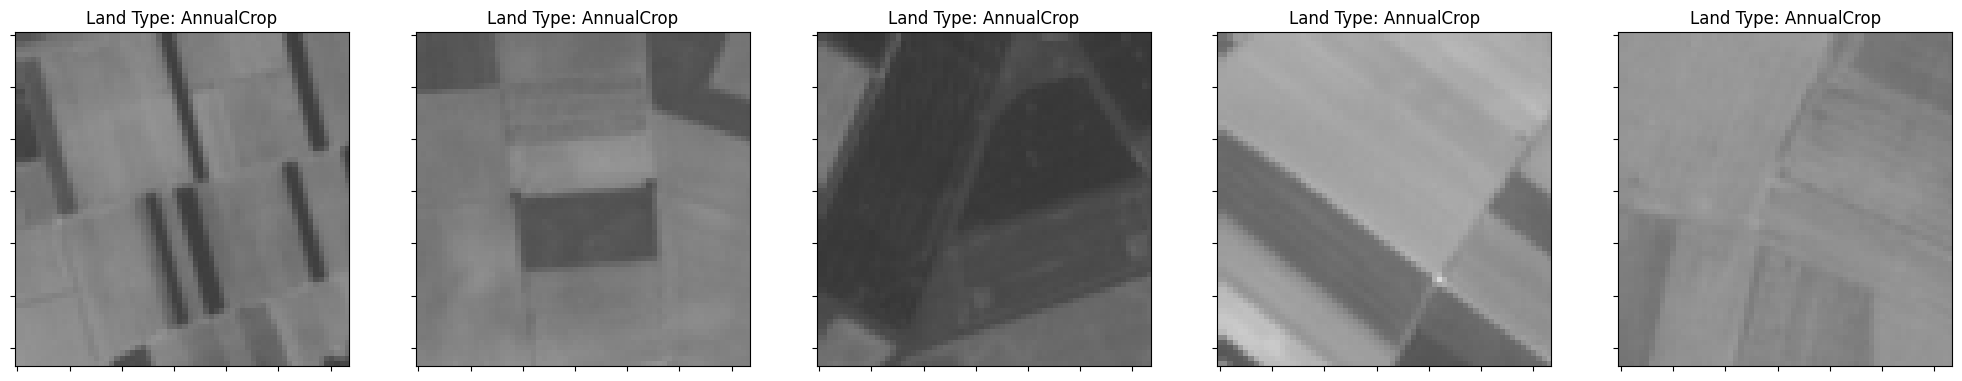

In [ ]:
plot_land_cover_type(data, land_types, label = 0)

##Forest

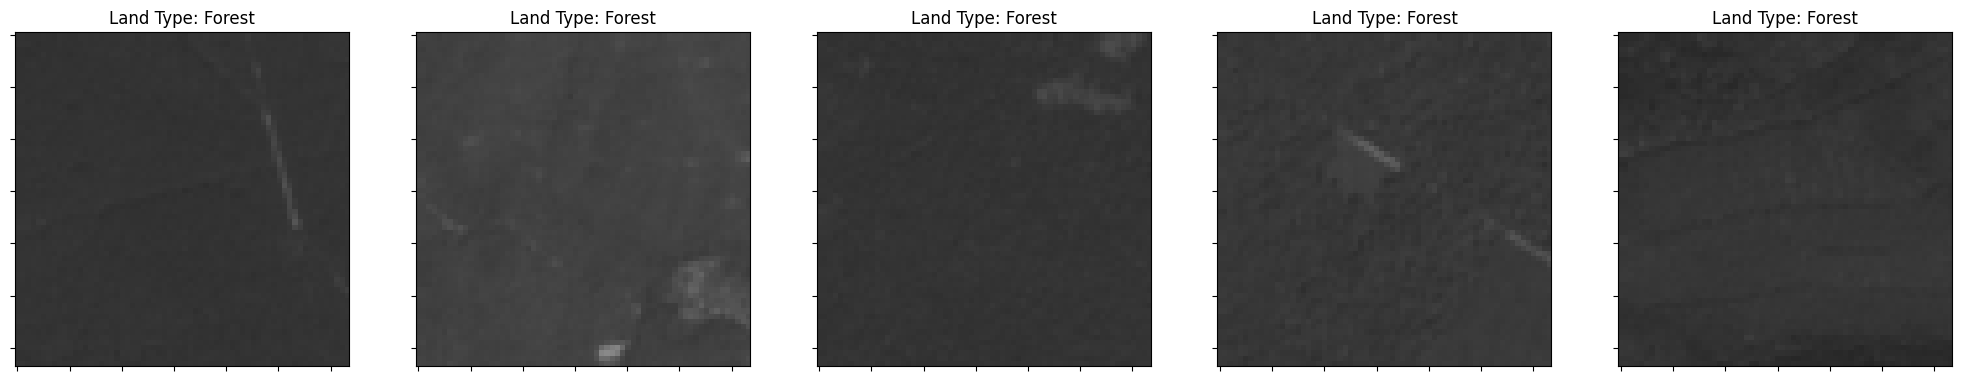

In [ ]:
plot_land_cover_type(data, land_types, label = 1)

## Herbaceous Vegetation

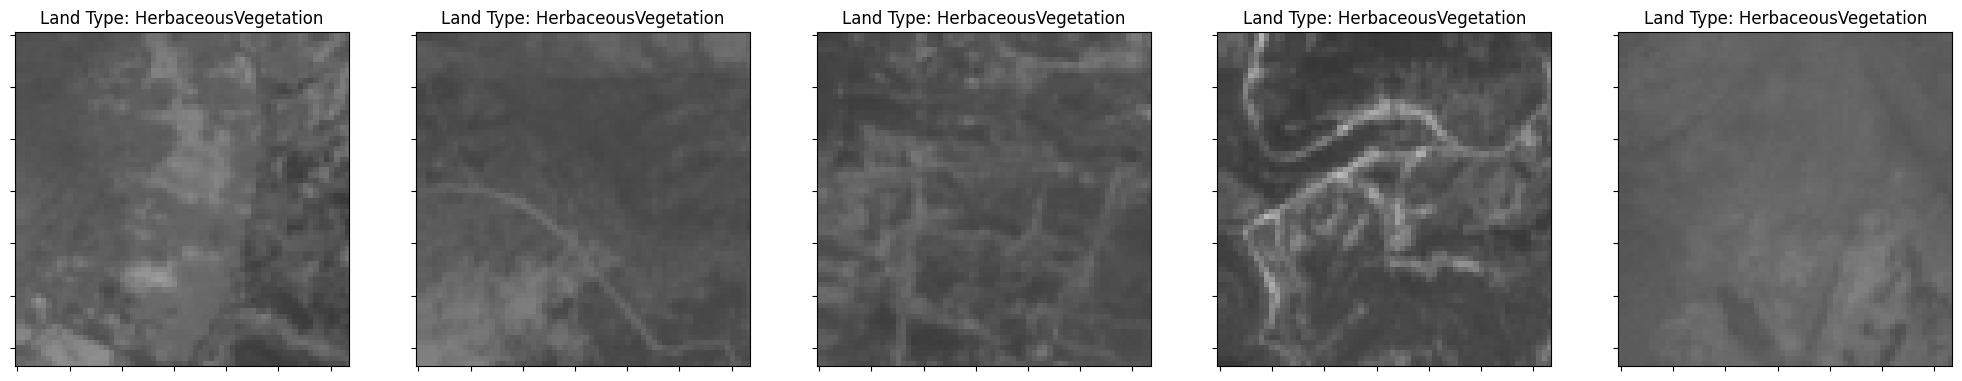

In [ ]:
plot_land_cover_type(data, land_types, label = 2)

## Highway

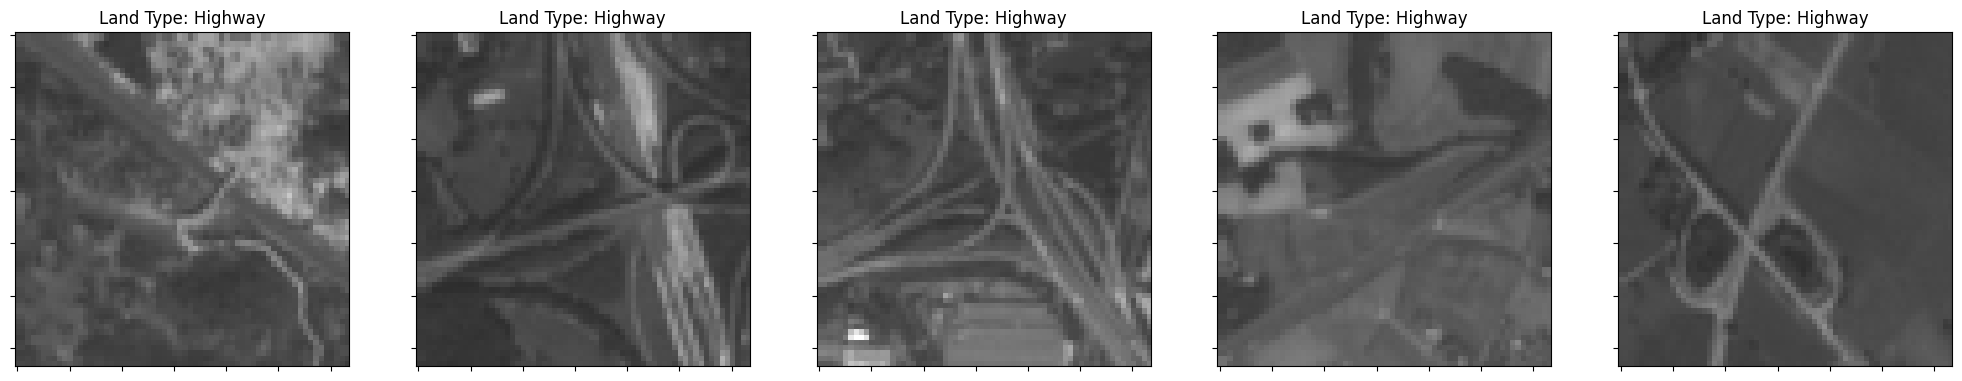

In [ ]:
plot_land_cover_type(data, land_types, label = 3)

## Industrial

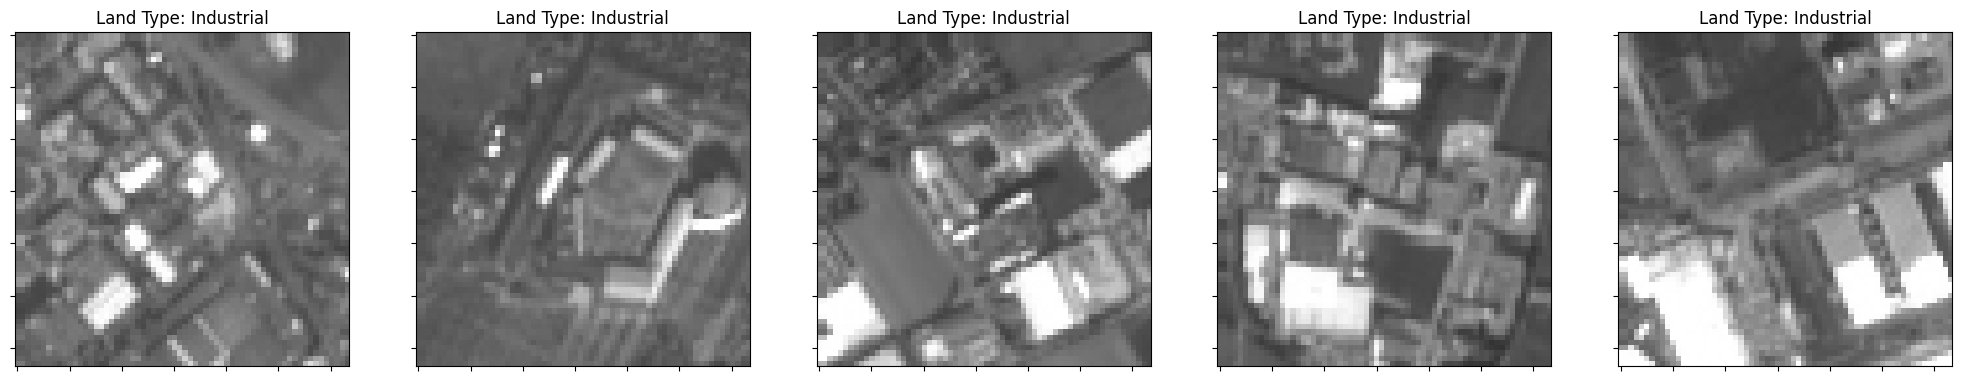

In [ ]:
plot_land_cover_type(data, land_types, label = 4)

## Pasture

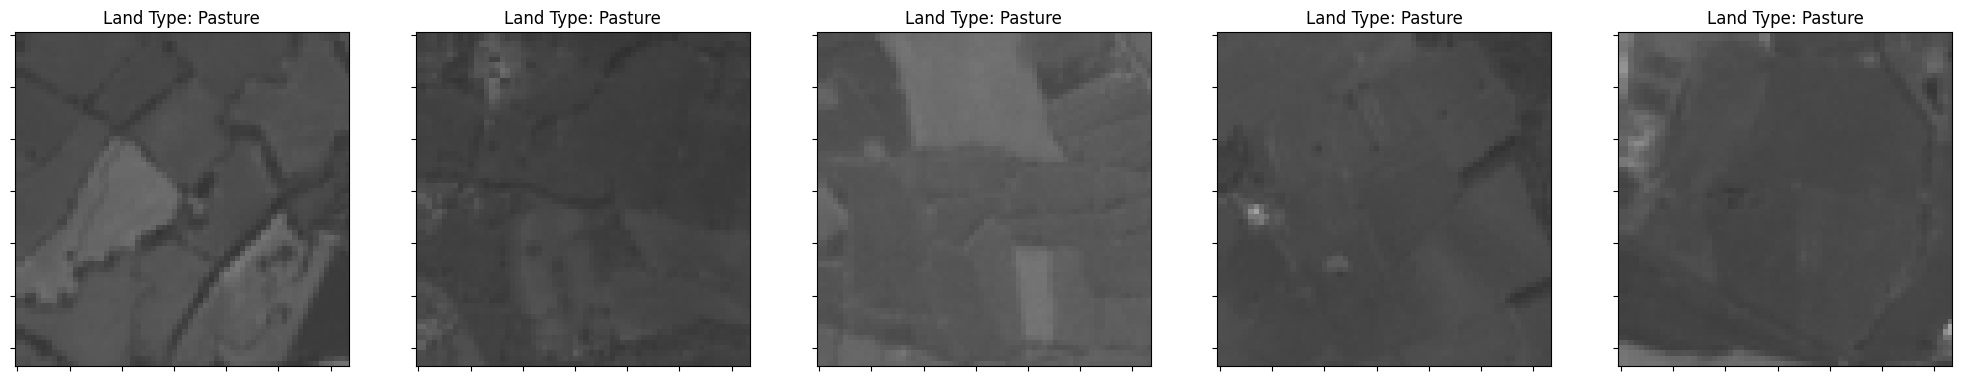

In [ ]:
plot_land_cover_type(data, land_types, label = 5)

## Permanent Crop

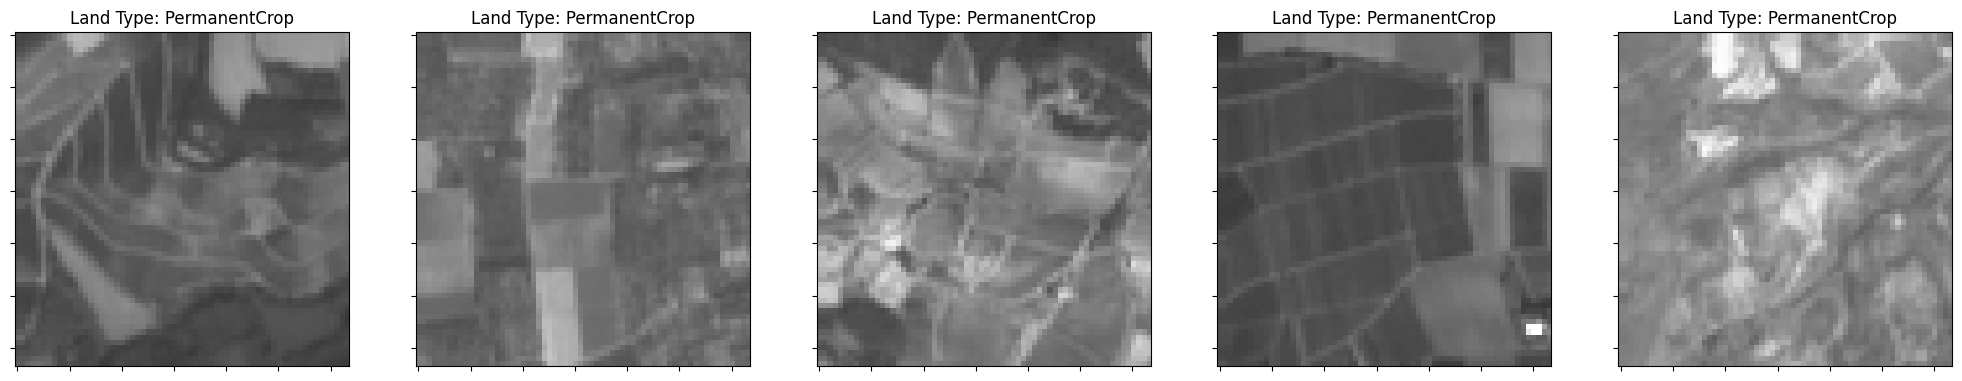

In [ ]:
plot_land_cover_type(data, land_types, label = 6)

## Residental

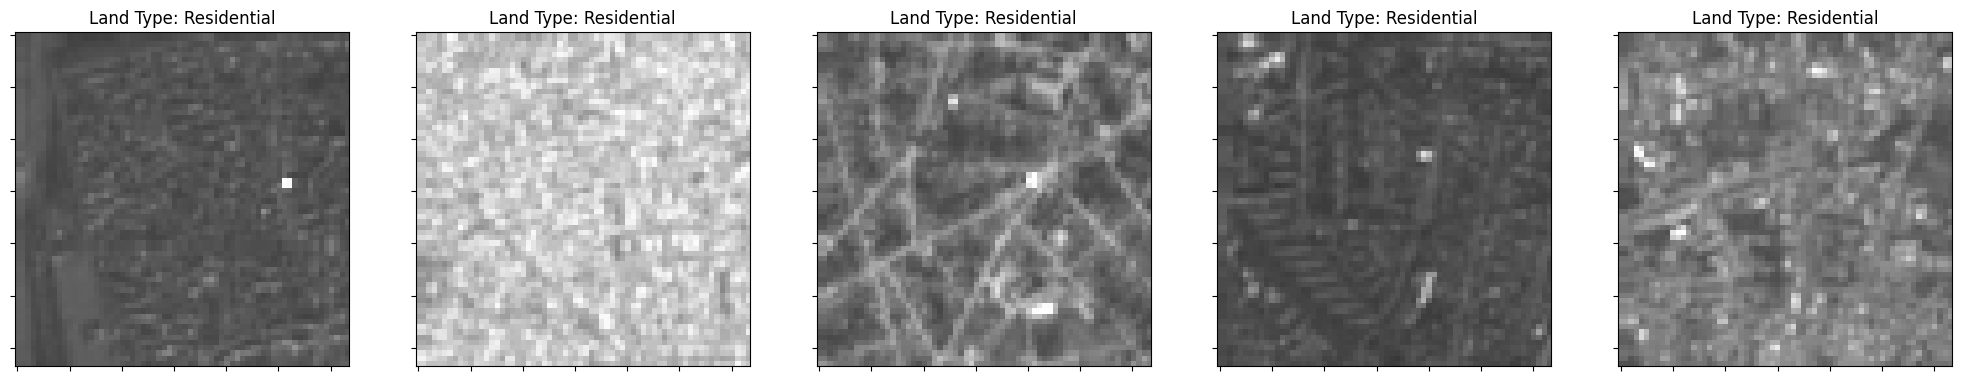

In [ ]:
plot_land_cover_type(data, land_types, label = 7)

## River

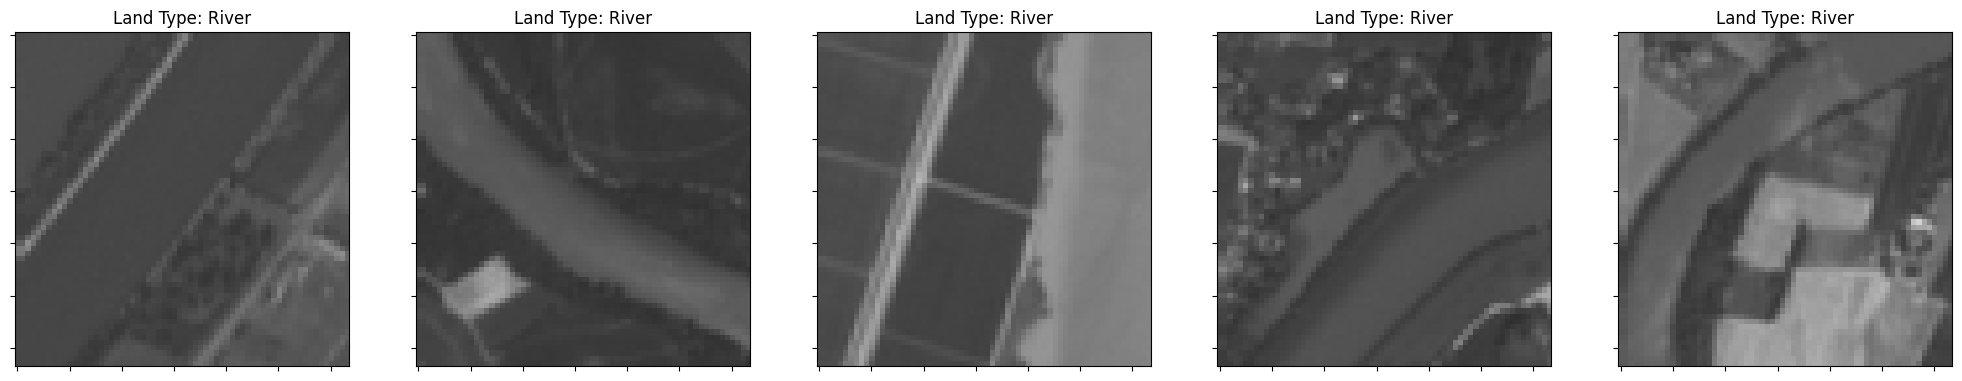

In [ ]:
plot_land_cover_type(data, land_types, label = 8)

## Sealake

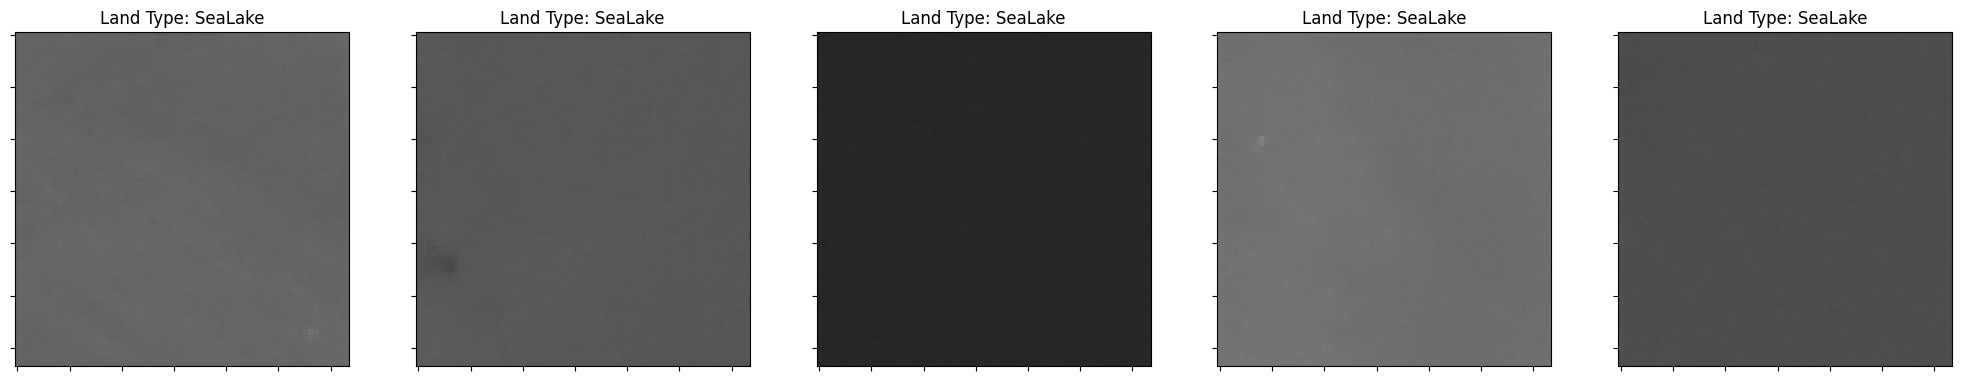

In [ ]:
plot_land_cover_type(data, land_types, label = 9)

# Shuffle Data

In [ ]:
import pandas as pd
from sklearn.utils import shuffle

# Assuming your data is stored in a DataFrame called 'data'

# Shuffle the entire DataFrame
data = shuffle(data)

# Reorder the data based on the 'Usage' column
data = data.sort_values('Usage', key=lambda col: col.map({'Training': 0, 'Validation': 1, 'Test': 2}))

# Reset the index of the shuffled and reordered data
data = data.reset_index(drop=True)


In [ ]:
data

,Pixels,Class,Usage
0,66 66 52 55 57 62 73 76 71 55 52 60 87 92 85 7...,4,Training
1,120 120 125 121 118 115 117 126 127 121 115 11...,2,Training
2,57 57 57 59 56 59 60 70 76 78 72 69 86 77 92 1...,8,Training
3,102 102 100 100 100 102 102 101 101 101 101 10...,9,Training
4,80 80 77 79 78 84 93 102 102 101 96 92 95 101 ...,2,Training
...,...,...,...
26995,144 144 143 141 141 142 141 140 141 141 141 14...,0,Test
26996,159 159 159 159 161 163 163 157 135 138 138 14...,6,Test
26997,103 103 91 84 72 102 94 76 83 101 89 103 90 83...,7,Test
26998,112 112 94 81 94 114 126 112 104 109 107 102 1...,7,Test


In [ ]:
data['Usage'].value_counts()

Training      21600
Validation     2700
Test           2700
Name: Usage, dtype: int64

# Data Preparation

In [ ]:
def prepare_data(data):

    image_array = np.zeros(shape=(len(data), 64, 64))
    image_label = np.array(list(map(int, data['Class'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'Pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (64, 64))
        image_array[i] = image

    return image_array, image_label

## Generating train, validation, and test data

In [ ]:
train_image_array, train_image_label = prepare_data(data[data['Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data['Usage']=='Validation'])
test_image_array, test_image_label = prepare_data(data[data['Usage']=='Test'])

In [ ]:
train_images = train_image_array.reshape((train_image_array.shape[0], 64, 64, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 64, 64, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 64, 64, 1))
test_images = test_images.astype('float32')/255

In [ ]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

In [ ]:
train_generator = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range = 0.15,
    zoom_range = 0.15,
    horizontal_flip = True,
    fill_mode='nearest'
)
valid_generator = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range = 0.15,
    zoom_range = 0.15,
    horizontal_flip = True,
    fill_mode='nearest'
)
train_generator.fit(train_images)
valid_generator.fit(val_images)

In [ ]:
class_weight = dict(zip(range(0, 10), (((data[data['Usage']=='Training']['Class'].value_counts()).sort_index())/len(data[data['Usage']=='Training']['Class'])).tolist()))
class_weight = {k: round(v, 2) for k, v in class_weight.items()}

In [ ]:
class_weight

{0: 0.11,
 1: 0.11,
 2: 0.11,
 3: 0.09,
 4: 0.09,
 5: 0.07,
 6: 0.09,
 7: 0.11,
 8: 0.09,
 9: 0.11}

# First model


In [ ]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 9216)              0

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=1e-2, patience=10, verbose=1, restore_best_weights=True)
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=1e-1, patience=5, verbose=1, min_delta=1e-2)

In [ ]:
history = model.fit(train_generator.flow(train_images, train_labels),
                    validation_data=valid_generator.flow(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=35,
                    verbose=1,
                    batch_size=32,
                    callbacks=[early_stop, reduce_lr_on_plateau],
                    )

Epoch 1/35
675/675 [==============================] - 24s 20ms/step - loss: 0.1397 - accuracy: 0.4478 - val_loss: 1.2177 - val_accuracy: 0.5330 - lr: 0.0010
Epoch 2/35
675/675 [==============================] - 13s 19ms/step - loss: 0.1028 - accuracy: 0.6025 - val_loss: 0.9751 - val_accuracy: 0.6522 - lr: 0.0010
Epoch 3/35
675/675 [==============================] - 14s 21ms/step - loss: 0.0922 - accuracy: 0.6412 - val_loss: 0.8867 - val_accuracy: 0.6815 - lr: 0.0010
Epoch 4/35
675/675 [==============================] - 13s 20ms/step - loss: 0.0852 - accuracy: 0.6700 - val_loss: 0.9040 - val_accuracy: 0.6474 - lr: 0.0010
Epoch 5/35
675/675 [==============================] - 13s 20ms/step - loss: 0.0816 - accuracy: 0.6835 - val_loss: 0.7824 - val_accuracy: 0.7044 - lr: 0.0010
Epoch 6/35
675/675 [==============================] - 13s 20ms/step - loss: 0.0776 - accuracy: 0.6950 - val_loss: 0.8152 - val_accuracy: 0.7019 - lr: 0.0010
Epoch 7/35
675/675 [==============================] - 13s 

## Test Accuracy Score

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test caccuracy:', test_acc)

85/85 [==============================] - 0s 2ms/step - loss: 0.3887 - accuracy: 0.8663
test caccuracy: 0.8662962913513184


In [ ]:
pred_test_labels = model.predict(test_images)

85/85 [==============================] - 0s 2ms/step


## Loss function and accuracy score plot

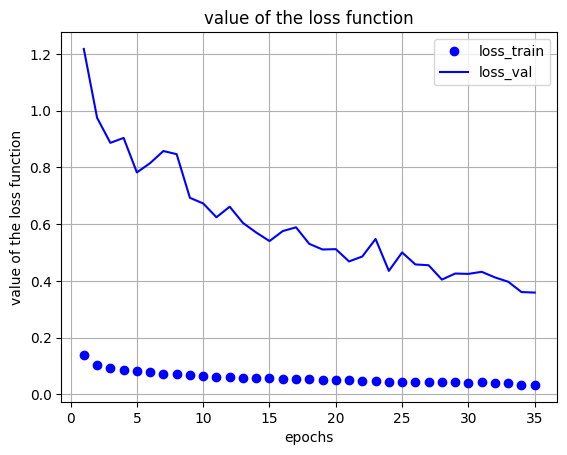

In [ ]:
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

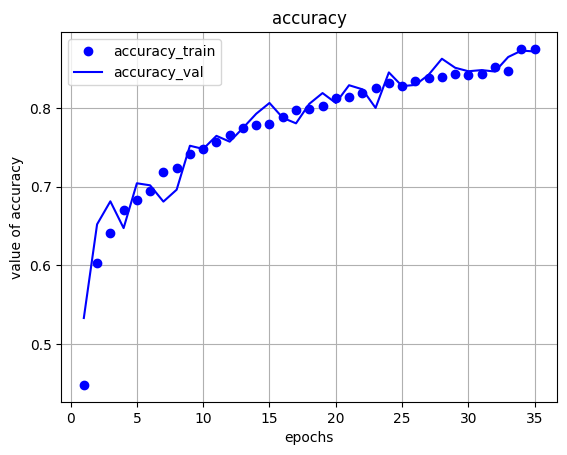

In [ ]:
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

## Confusion matrix

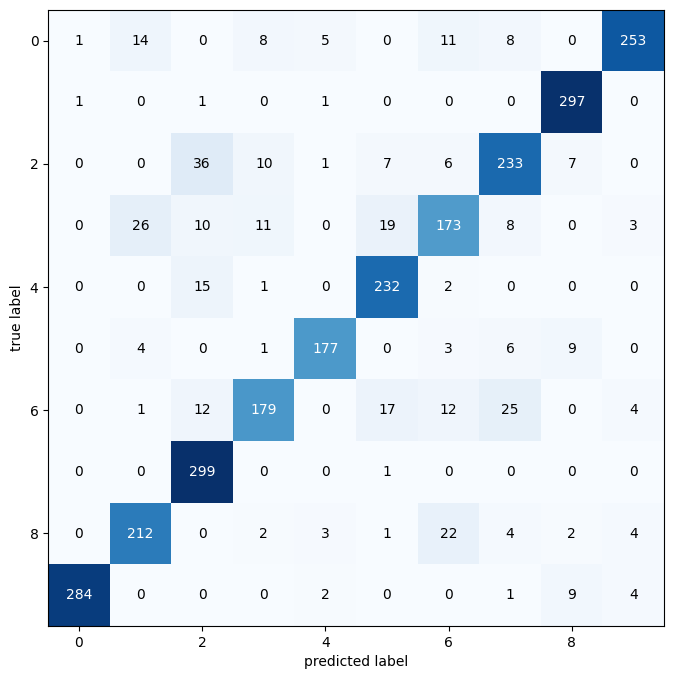

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

p=pred_test_labels.copy()
# reverse pred test label
p = p[:,::-1]
conf_mat = confusion_matrix(test_labels.argmax(axis=1), p.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=False,
                                show_absolute=True,
                                #class_names=land_types.values(),
                                figsize=(8, 8))
plt.show()

## Feature map visualization (GradCAM)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,self.model.output]
       )

        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
            grads = tape.gradient(loss, convOutputs)

            castConvOutputs = tf.cast(convOutputs > 0, "float32")
            castGrads = tf.cast(grads > 0, "float32")
            guidedGrads = castConvOutputs * castGrads * grads
            convOutputs = convOutputs[0]
            guidedGrads = guidedGrads[0]

            weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
            cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

            (w, h) = (image.shape[2], image.shape[1])
            heatmap = cv2.resize(cam.numpy(), (w, h))
            numer = heatmap - np.min(heatmap)
            denom = (heatmap.max() - heatmap.min()) + eps
            heatmap = numer / denom
            heatmap = (heatmap * 255).astype("uint8")
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap = cv2.COLORMAP_VIRIDIS):
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        return (heatmap, output)

1/1 [==============================] - 0s 20ms/step


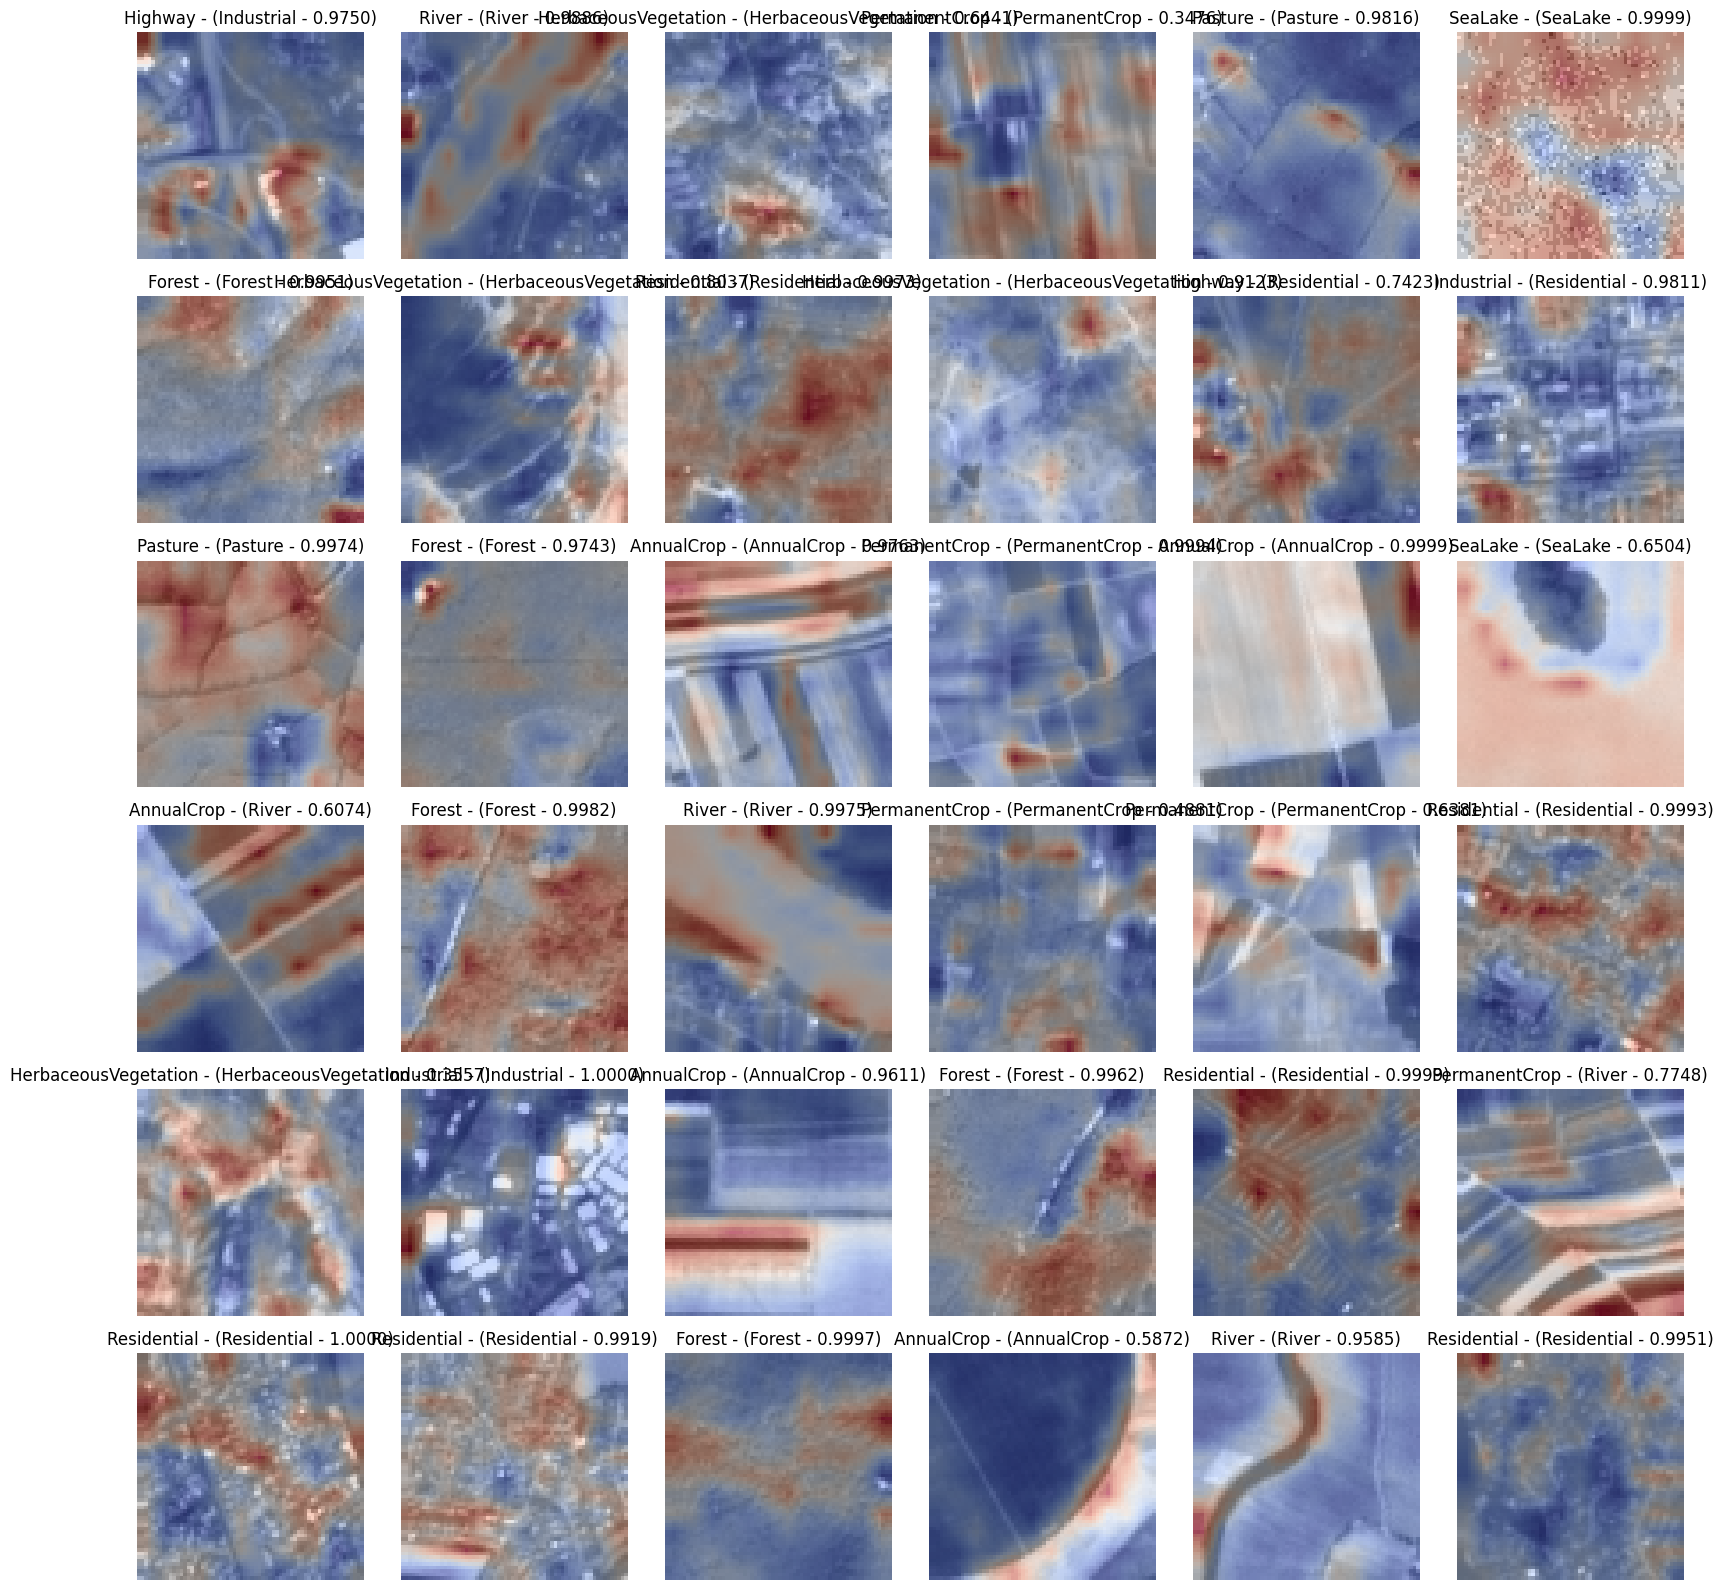

In [ ]:
plt.figure(figsize=[16,16])
for i in range(36):
    img = test_images[i,:,:,0]
    p_dist = model.predict(img.reshape(1,64,64,1))
    k = np.argmax(p_dist)
    p = np.max(p_dist)

    cam = GradCAM(model, k)
    heatmap = cam.compute_heatmap(img.reshape(1,64,64,1))

    plt.subplot(6,6,i+1)
    plt.imshow(img, cmap='binary_r')
    plt.imshow(heatmap, alpha=0.5, cmap='coolwarm')
    plt.title(f'{land_types[test_image_label[i]]} - ({land_types[k]} - {p:.4f})')
    plt.axis('off')
plt.tight_layout()
plt.show()

85/85 [==============================] - 0s 2ms/step


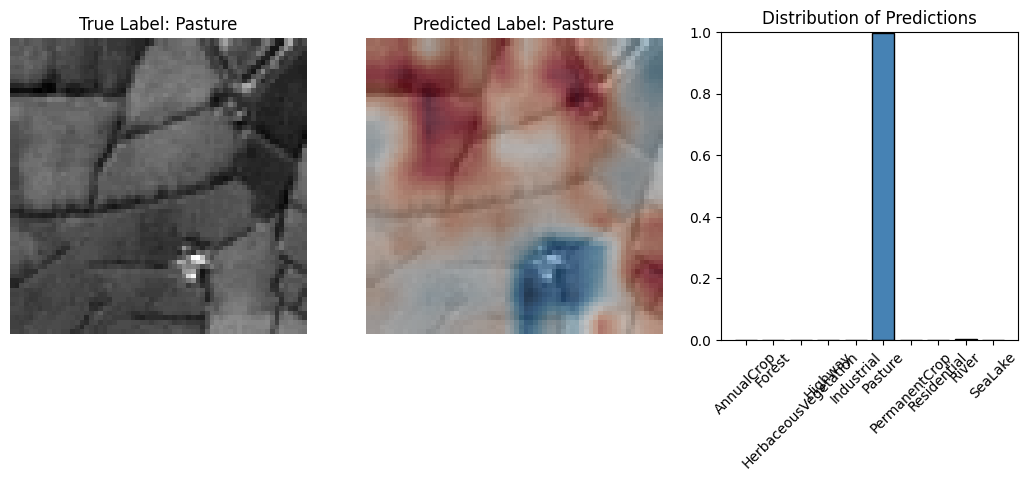

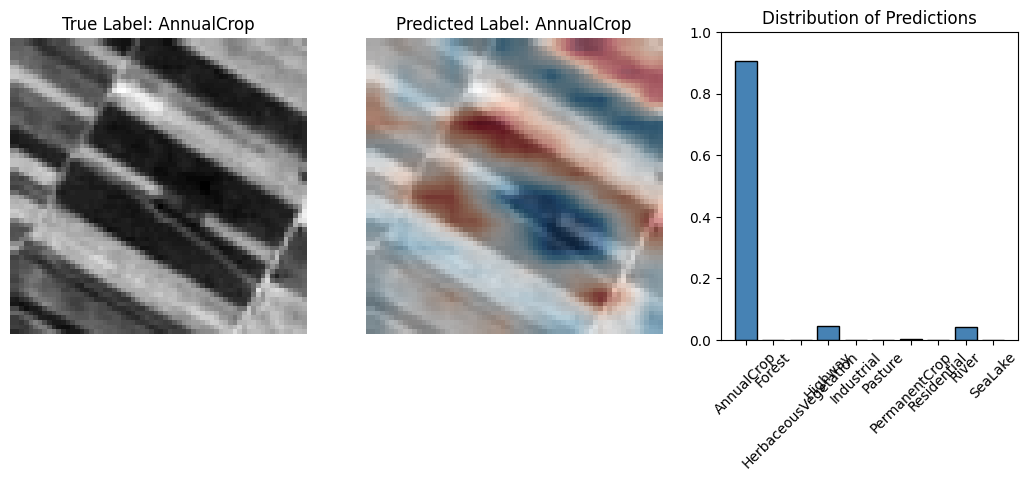

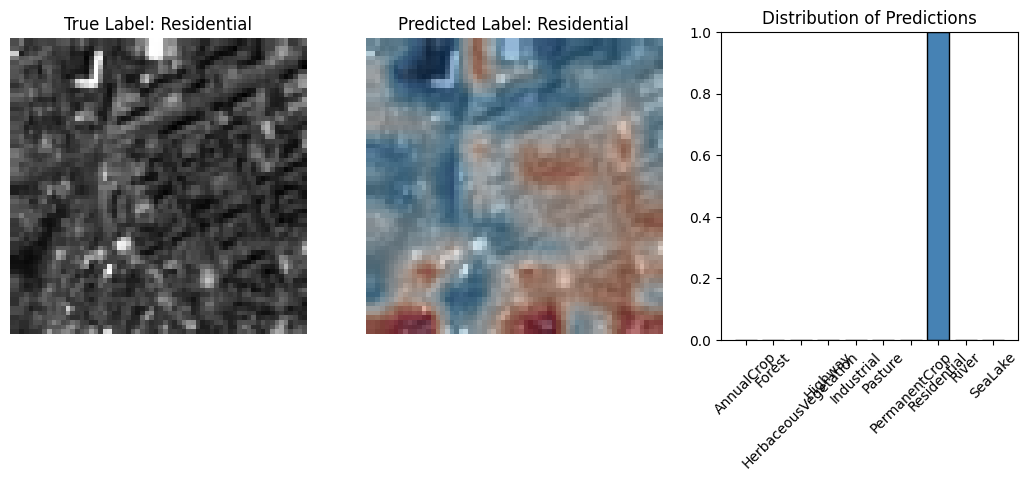

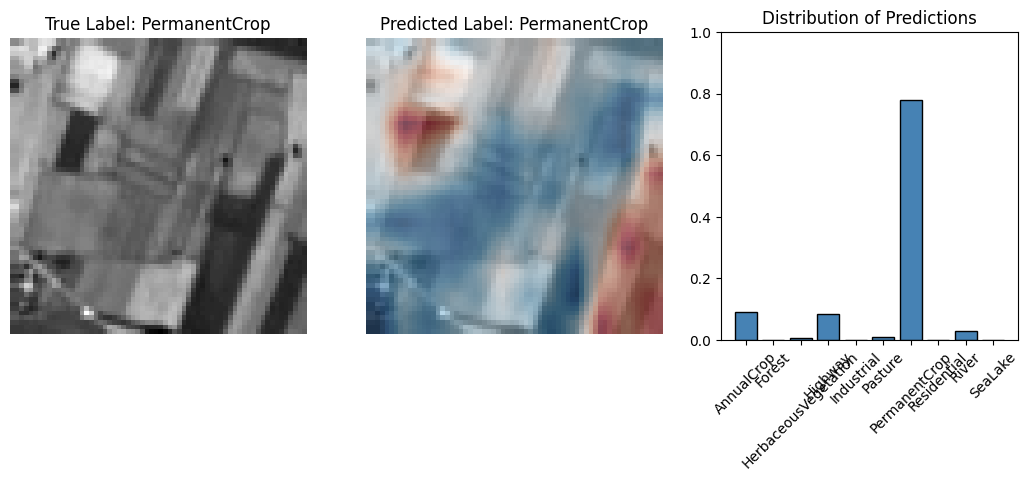

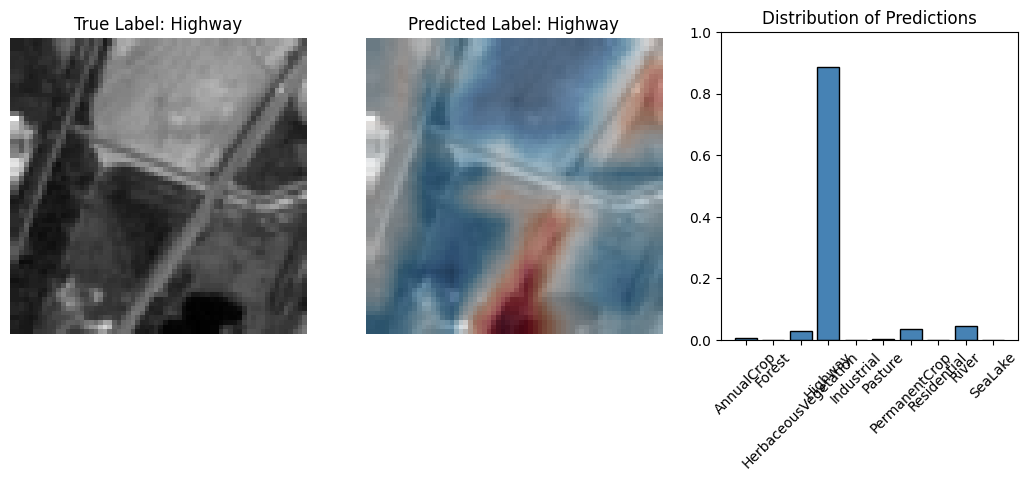

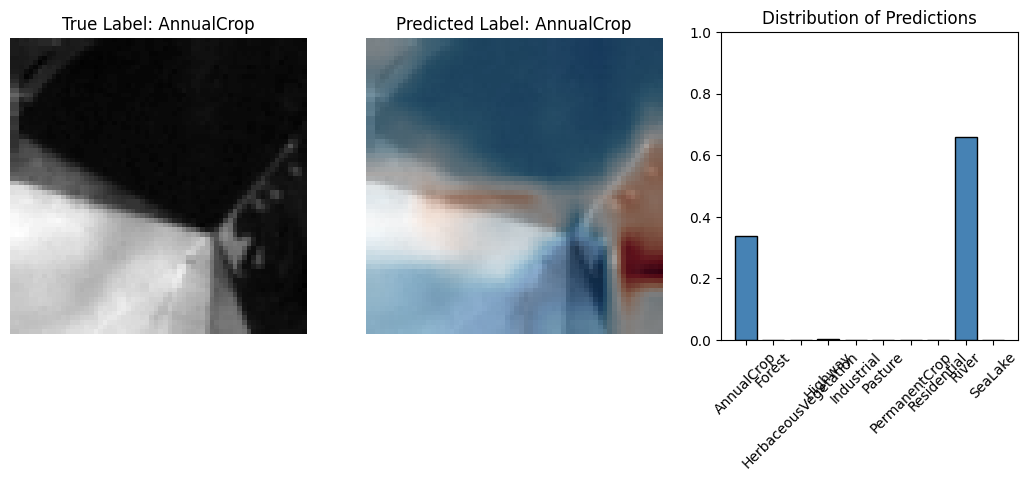

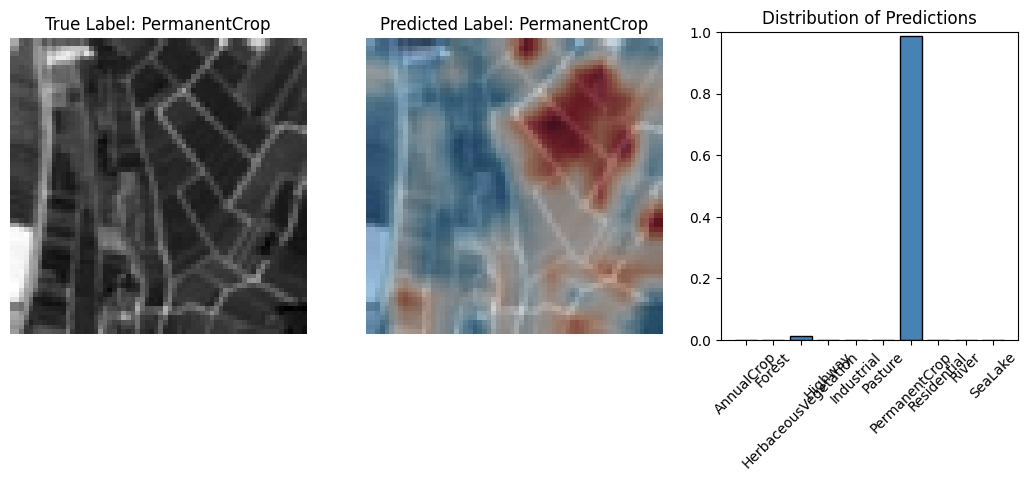

In [ ]:
test_prob = model.predict(test_images)
test_pred = np.argmax(test_prob, axis=1)

sel_imgs = [12, 312, 614, 1215, 1586, 1956, 2387]

for n in sel_imgs:
    img = test_images[n,:,:,0]

    plt.figure(figsize=[13,4])
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='binary_r')
    plt.title(f'True Label: {land_types[test_image_label[n]]}')
    plt.axis('off')

    cam = GradCAM(model, test_pred[n])
    heatmap = cam.compute_heatmap(img.reshape(1,64,64,1))

    plt.subplot(1, 3, 2)
    plt.imshow(img, cmap='binary_r')
    plt.imshow(heatmap, alpha=0.5, cmap='RdBu_r')
    plt.title(f'Predicted Label: {land_types[test_image_label[n]]}')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.bar(land_types.values(), test_prob[n, :], color='steelblue', edgecolor='k')
    plt.xticks(rotation=45)
    plt.ylim([0,1])
    plt.title('Distribution of Predictions')
    plt.show()

# Second model


In [ ]:
from keras import layers
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Flatten, Dense, BatchNormalization, Activation
from keras.models import Model
from keras import backend as K

def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2 = filters

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(name=bn_name_base + '2b')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)

    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    filters1, filters2 = filters

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(name=bn_name_base + '2b')(x)

    shortcut = Conv2D(filters2, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)

    return x

def ResNet18(input_shape=(64, 64, 1), num_classes=10):
    input_tensor = Input(shape=input_shape)

    x = ZeroPadding2D((3, 3))(input_tensor)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64], stage=2, block='b')

    x = conv_block(x, 3, [128, 128], stage=3, block='a')
    x = identity_block(x, 3, [128, 128], stage=3, block='b')

    x = conv_block(x, 3, [256, 256], stage=4, block='a')
    x = identity_block(x, 3, [256, 256], stage=4, block='b')

    x = conv_block(x, 3, [512, 512], stage=5, block='a')
    x = identity_block(x, 3, [512, 512], stage=5, block='b')

    x = AveragePooling2D((2, 2), name='avg_pool')(x)
    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax', name='fc10')(x)

    model2 = Model(inputs=input_tensor, outputs=x, name='resnet18')

    return model2

# Example usage:
model2 = ResNet18()
model2.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "resnet18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 zero_padding2d_3 (ZeroPadding2  (None, 70, 70, 1)   0           ['input_4[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 32, 32, 64)   3200        ['zero_padding2d_3[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1[0][0]']           

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=1e-2, patience=10, verbose=1, restore_best_weights=True)
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=1e-1, patience=5, verbose=1, min_delta=1e-2)

In [ ]:
history2 = model2.fit(train_generator.flow(train_images, train_labels),
                    validation_data=valid_generator.flow(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=45,
                    verbose=1,
                    batch_size=32,
                    callbacks=[early_stop, reduce_lr_on_plateau],
                    )

Epoch 1/45
675/675 [==============================] - 30s 22ms/step - loss: 0.1221 - accuracy: 0.5503 - val_loss: 3.0054 - val_accuracy: 0.3296 - lr: 0.0010
Epoch 2/45
675/675 [==============================] - 14s 21ms/step - loss: 0.0915 - accuracy: 0.6517 - val_loss: 2.7996 - val_accuracy: 0.3656 - lr: 0.0010
Epoch 3/45
675/675 [==============================] - 14s 21ms/step - loss: 0.0780 - accuracy: 0.7088 - val_loss: 1.9458 - val_accuracy: 0.4644 - lr: 0.0010
Epoch 4/45
675/675 [==============================] - 15s 22ms/step - loss: 0.0693 - accuracy: 0.7425 - val_loss: 3.6934 - val_accuracy: 0.2852 - lr: 0.0010
Epoch 5/45
675/675 [==============================] - 15s 22ms/step - loss: 0.0615 - accuracy: 0.7752 - val_loss: 4.3853 - val_accuracy: 0.2596 - lr: 0.0010
Epoch 6/45
675/675 [==============================] - 14s 21ms/step - loss: 0.0554 - accuracy: 0.7975 - val_loss: 1.6019 - val_accuracy: 0.5244 - lr: 0.0010
Epoch 7/45
675/675 [==============================] - 14s 

## Test Accuracy Score

In [ ]:
test_loss2, test_acc2 = model2.evaluate(test_images, test_labels)
print('test caccuracy:', test_acc2)

85/85 [==============================] - 0s 4ms/step - loss: 0.3022 - accuracy: 0.9056
test caccuracy: 0.9055555462837219


In [ ]:
pred_test_labels2 = model2.predict(test_images)

85/85 [==============================] - 1s 3ms/step


## Loss function and accuracy score plot

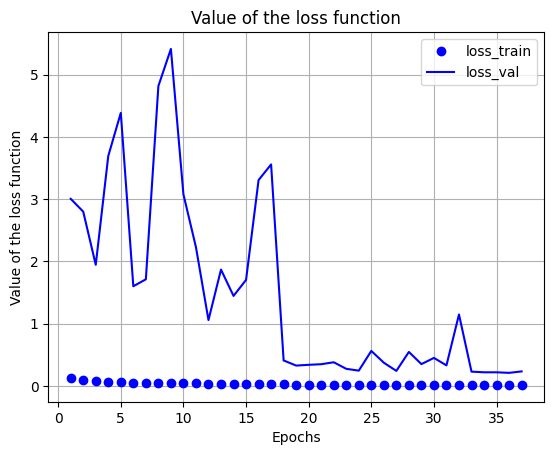

In [ ]:
loss2 = history2.history['loss']
loss_val2 = history2.history['val_loss']
epochs = range(1, len(loss2)+1)  # Use len(loss2) instead of len(loss)
plt.plot(epochs, loss2, 'bo', label='loss_train')
plt.plot(epochs, loss_val2, 'b', label='loss_val')
plt.title('Value of the loss function')
plt.xlabel('Epochs')
plt.ylabel('Value of the loss function')
plt.legend()
plt.grid()
plt.show()

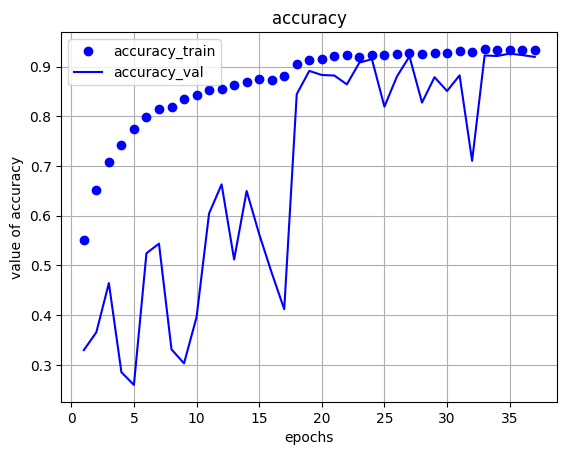

In [ ]:
acc2 = history2.history['accuracy']
acc_val2 = history2.history['val_accuracy']
epochs = range(1, len(loss2)+1)
plt.plot(epochs, acc2, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val2, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

## Confusion matrix

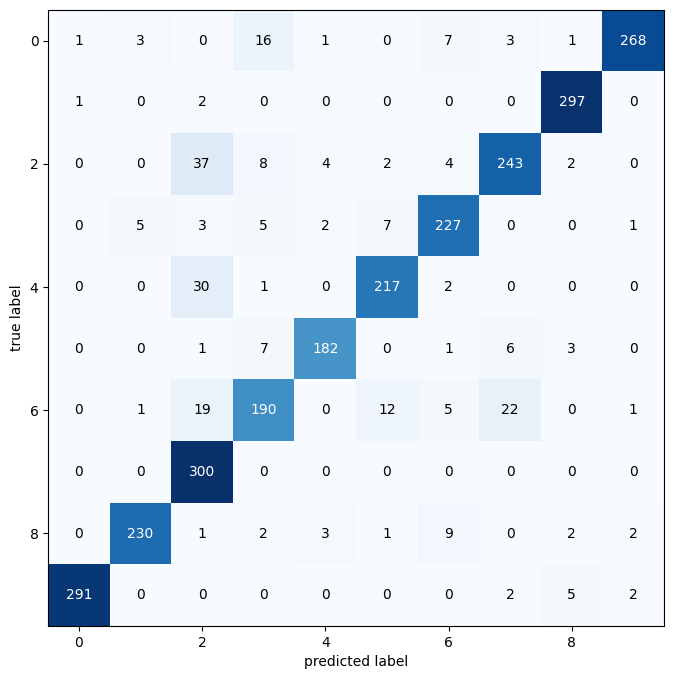

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

p2=pred_test_labels2.copy()
# reverse pred test label
p2 = p2[:,::-1]
conf_mat2 = confusion_matrix(test_labels.argmax(axis=1), p2.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat2,
                                show_normed=False,
                                show_absolute=True,
                                #class_names=land_types.values(),
                                figsize=(8, 8))
plt.show()

## Feature map visualization (GradCAM)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,self.model.output]
       )

        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
            grads = tape.gradient(loss, convOutputs)

            castConvOutputs = tf.cast(convOutputs > 0, "float32")
            castGrads = tf.cast(grads > 0, "float32")
            guidedGrads = castConvOutputs * castGrads * grads
            convOutputs = convOutputs[0]
            guidedGrads = guidedGrads[0]

            weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
            cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

            (w, h) = (image.shape[2], image.shape[1])
            heatmap = cv2.resize(cam.numpy(), (w, h))
            numer = heatmap - np.min(heatmap)
            denom = (heatmap.max() - heatmap.min()) + eps
            heatmap = numer / denom
            heatmap = (heatmap * 255).astype("uint8")
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap = cv2.COLORMAP_VIRIDIS):
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        return (heatmap, output)

1/1 [==============================] - 0s 22ms/step


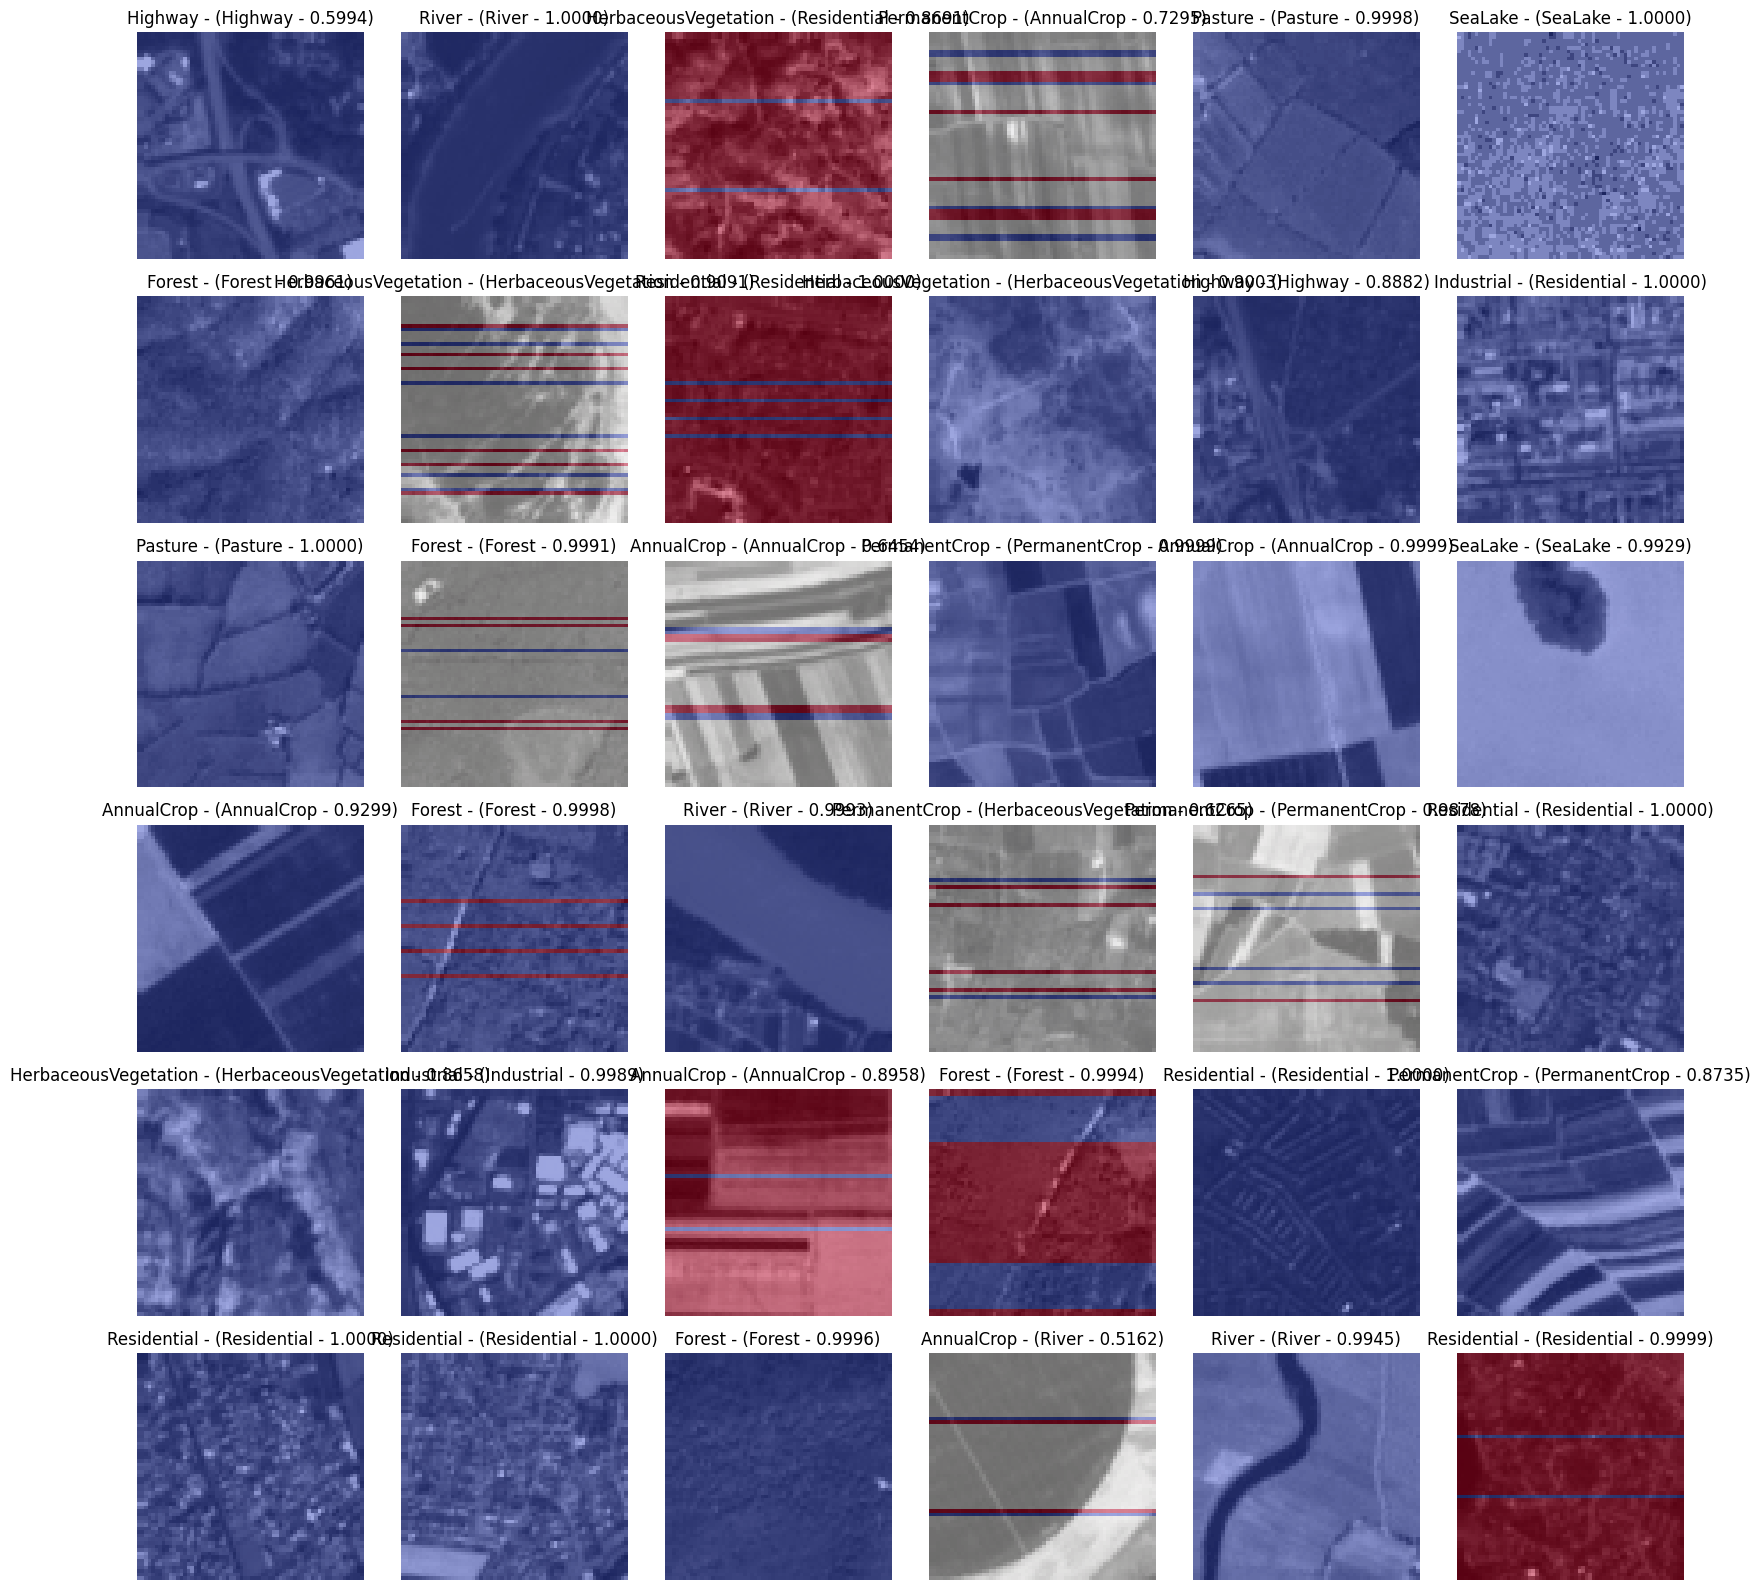

In [ ]:
plt.figure(figsize=[16,16])
for i in range(36):
    img = test_images[i,:,:,0]
    p_dist = model2.predict(img.reshape(1,64,64,1))
    k = np.argmax(p_dist)
    p = np.max(p_dist)

    cam = GradCAM(model2, k)
    heatmap = cam.compute_heatmap(img.reshape(1,64,64,1))

    plt.subplot(6,6,i+1)
    plt.imshow(img, cmap='binary_r')
    plt.imshow(heatmap, alpha=0.5, cmap='coolwarm')
    plt.title(f'{land_types[test_image_label[i]]} - ({land_types[k]} - {p:.4f})')
    plt.axis('off')
plt.tight_layout()
plt.show()

85/85 [==============================] - 0s 3ms/step


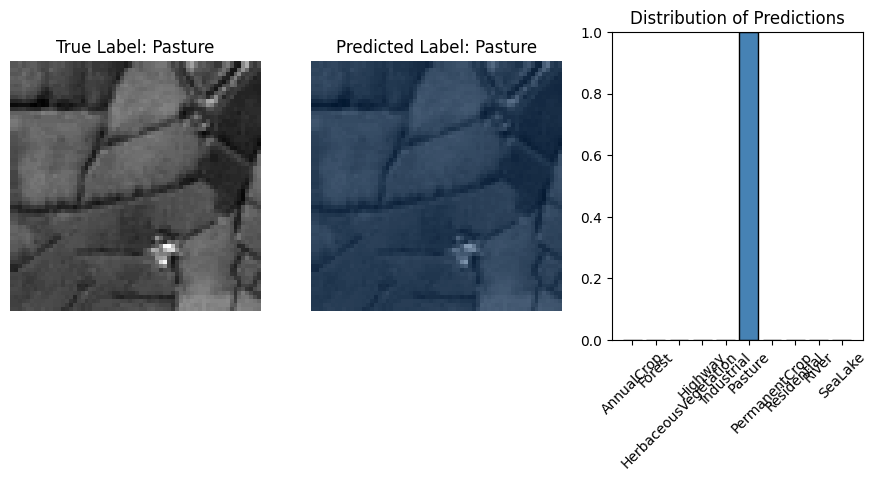

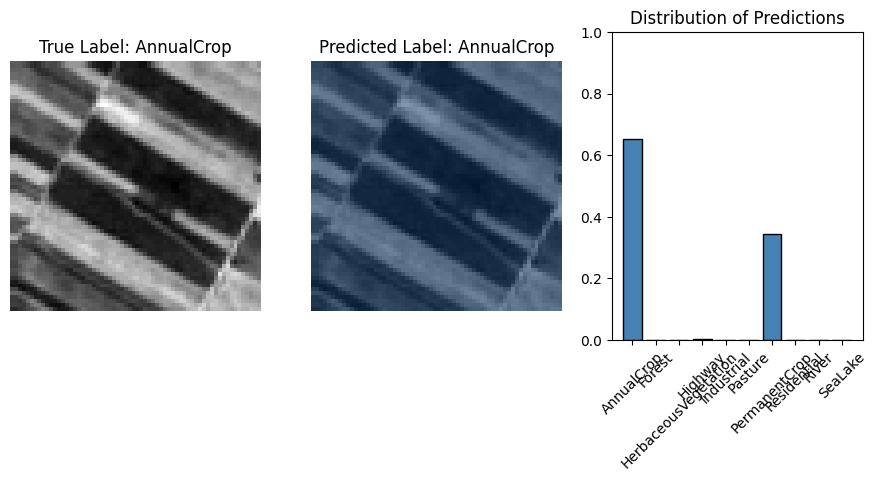

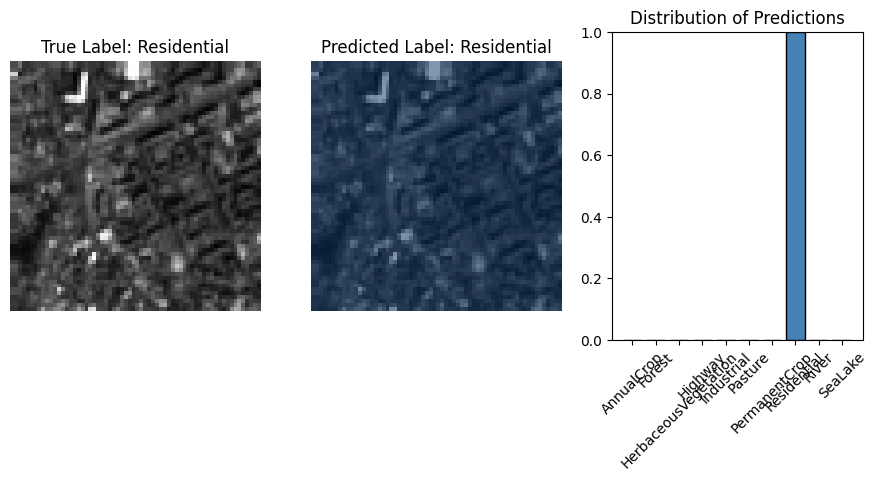

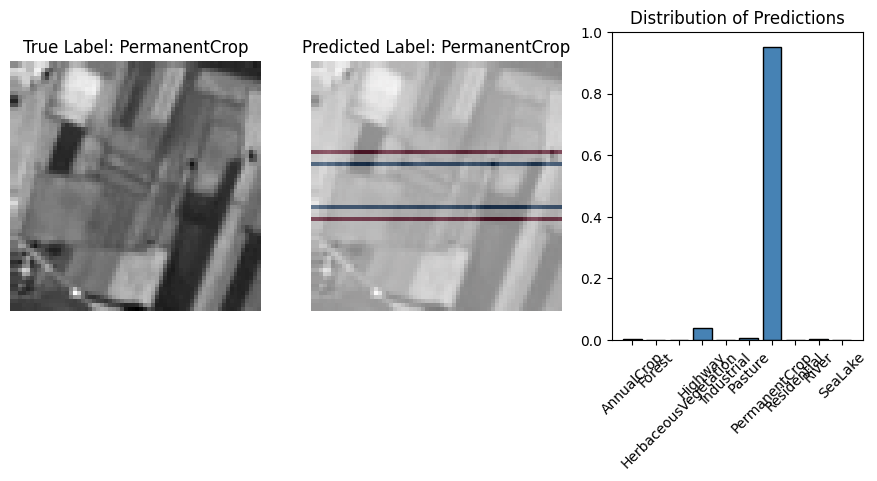

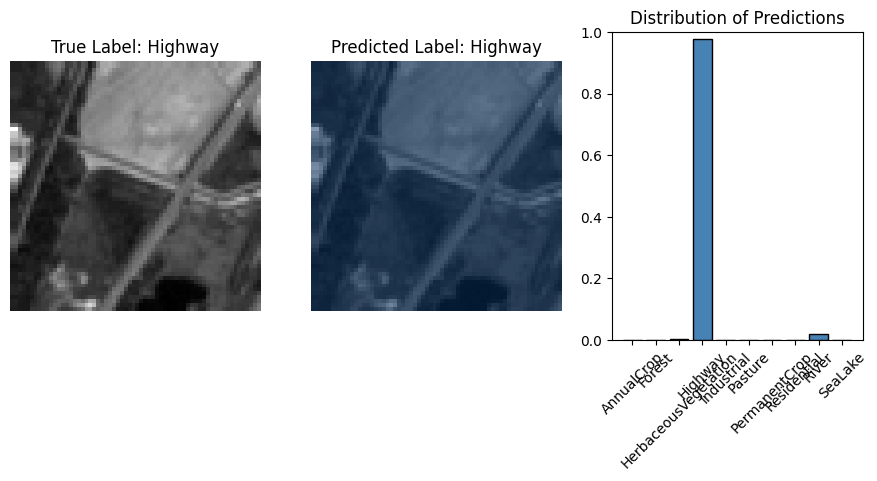

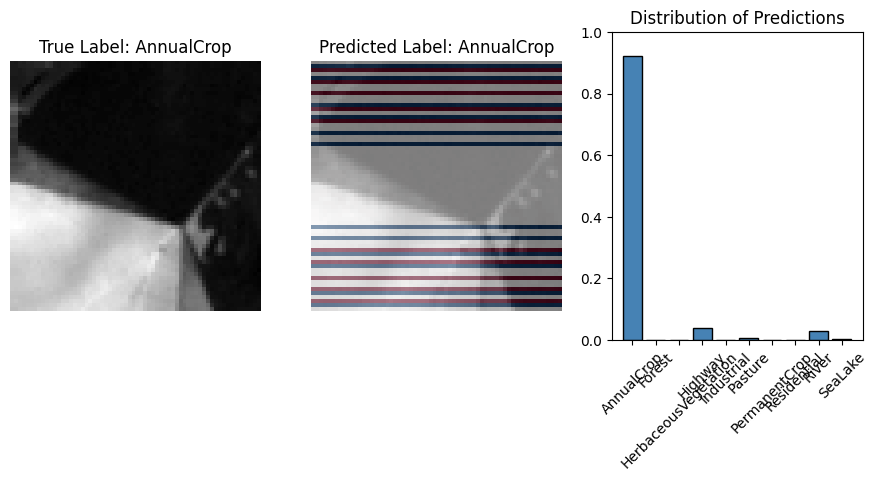

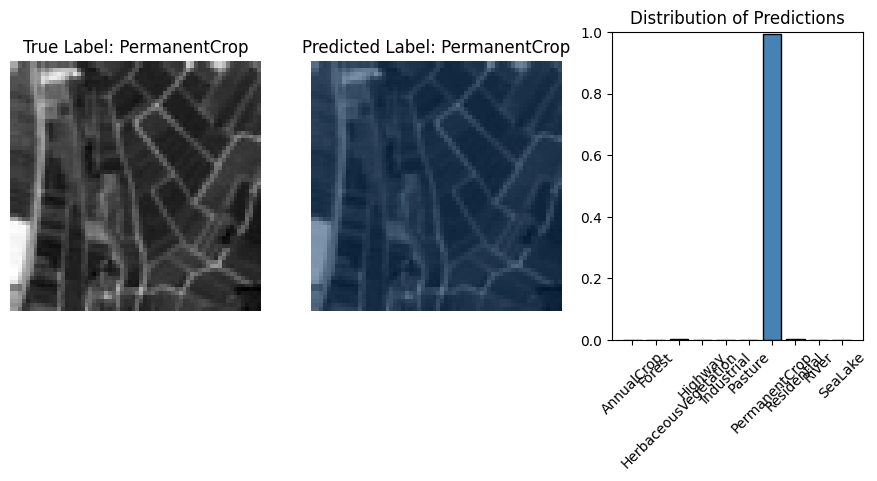

In [ ]:
test_prob2 = model2.predict(test_images)
test_pred2 = np.argmax(test_prob2, axis=1)

sel_imgs = [12, 312, 614, 1215, 1586, 1956, 2387]

for n in sel_imgs:
    img = test_images[n,:,:,0]

    plt.figure(figsize=[11,4])
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='binary_r')
    plt.title(f'True Label: {land_types[test_image_label[n]]}')
    plt.axis('off')

    cam = GradCAM(model2, test_pred2[n])
    heatmap = cam.compute_heatmap(img.reshape(1,64,64,1))

    plt.subplot(1, 3, 2)
    plt.imshow(img, cmap='binary_r')
    plt.imshow(heatmap, alpha=0.5, cmap='RdBu_r')
    plt.title(f'Predicted Label: {land_types[test_image_label[n]]}')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.bar(land_types.values(), test_prob2[n, :], color='steelblue', edgecolor='k')
    plt.xticks(rotation=45)
    plt.ylim([0,1])
    plt.title('Distribution of Predictions')
    plt.show()

# Summary

Jadi dalam tugas kali ini, kami menggunakan dataset berupa gambar yang berasal dari EuroSAT Land Cover Dataset [[1]](https://paperswithcode.com/dataset/eurosat). Kami menggunakan dua buah model untuk mengklasifikasi gambar, kedua model tersebut adalah sebagai berikut:

**1. Model Pertama**

Pada model pertama, kami menyusun arsitektur sederhana dengan susunan sebagai berikut:

![image.png](attachment:image.png)

Dengan menggunakan model tersebut, didapatkan akurasi test sebesar 0.866.

Kemudian, divisualisasikan juga plot dari loss function dan accuracy score dari model tersebut. Selain itu, didapat juga grafik confussion matrix dan feature map dengan GradCAM yang menunjukkan fitur-fitur mana saja yang berperan penting dalam penentuan label.

**2. Model Kedua (ResNet 18)**

Kami mengambil model ResNet 18 ini berdasarkan jurnal penelitian mengenai klasifikasi gambar EuroSAT [[2]](https://arxiv.org/abs/1709.00029) dan menurut *leaderboard* [[3]](https://paperswithcode.com/sota/image-classification-on-eurosat) menjadi salah satu arsitektur dengan akurasi tertinggi untuk dataset ini. Kami menggunakan model ResNet 18 dengan susunan sebagai berikut:


![image.png](attachment:image.png)

Terdapat Dengan menggunakan model tersebut, didapat akurasi sebesar 0.905.

Kemudian, divisualisasikan juga plot dari loss function dan accuracy score dari model tersebut. Namun, feature map di model kedua ini cukup berbeda dengan model pertama karena seakan terdapat anomali dan tidak menunjukkan fitur yang berperan penting dalam penentuan label dengan baik.